## Getting words in order with convolutional neural networks (CNNs)

Using neural networks for NLP

Finding meaning in word patterns

Building a CNN

Vectorizing natural language text in a way that suits neural networks

Training a CNN

Classifying the sentiment of novel text

 ### Learning meaning

Words Order

The dog chased the cat.

The cat chased the dog.

스킵그램을 쓰면 위 문장을 같은 문장이라고 인식한다. (단어가 나오는 순서는 생각하지 않으므로)

The ship's hull, despite years at sea, millions of tons of cargo, and two mid-sea collisions, shone like new.

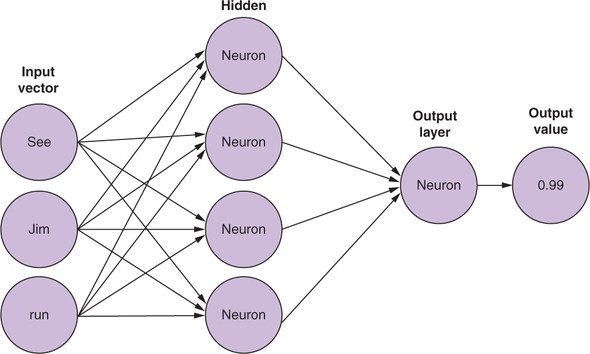

### Convolutional neural nets

아주 간단하게 생각해서 윈도우를 중심으로 옆으로 움직여가면서 계산한다.

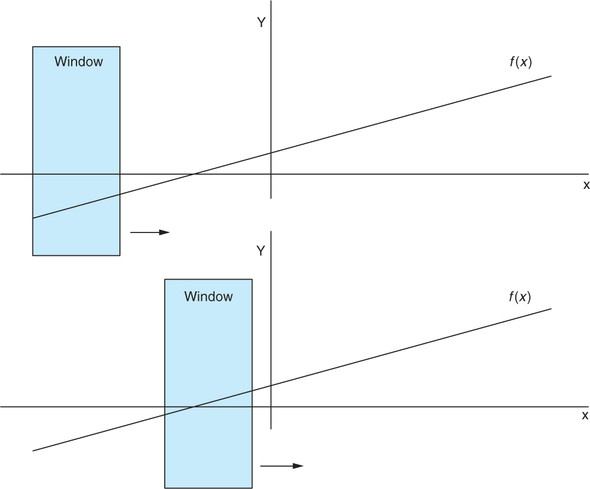

Window convolving over function

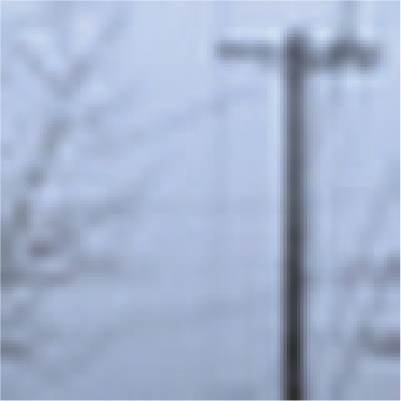

Small telephone pole image

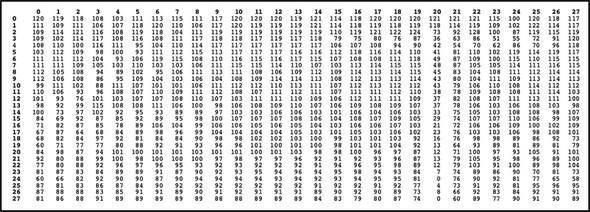

Pixel values for the telephone pole image

### Filter composition

Filters are composed of two parts:

1. weights
2. activation function

한 윈도우에 대한 (각각의 w * 각각의 인풋)

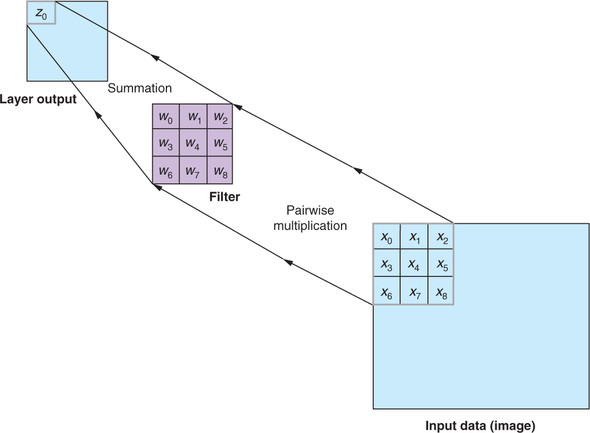

Convolutional neural net step

옆으로 한 칸 옮겨서 또 계산

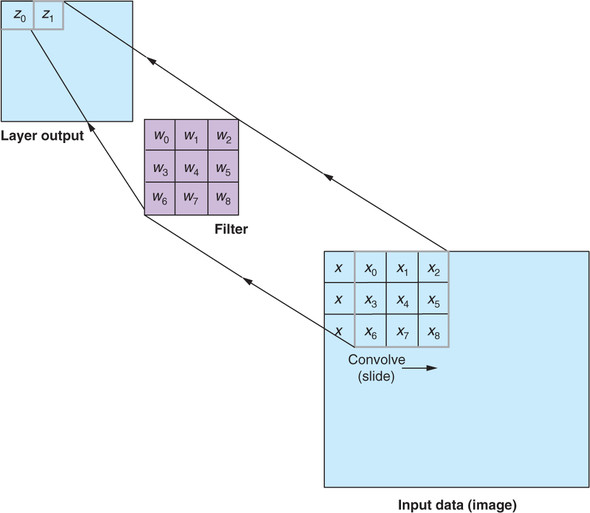

단 이렇게 하면 제일 가장자리에 있는 열은 한 번만 계산되기 때문에 아래 padding 으로 보정한다.

물론 아주 큰 데이터(혹은 이미지)라면 무시할 수도 있다.

### Padding

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D
 
model = Sequential()
model.add(Conv1D(filters=16,
                     kernel_size=3,
                     padding='same',
                      activation='relu',
                     strides=1,
                     input_shape=(100, 300)))

### Narrow windows indeed

워드에서도 윈도우를 만들어 옆으로 옮기며 계산

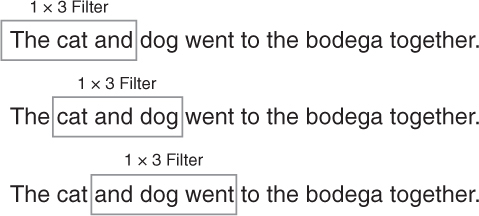

각 단어는 6가지 의미 벡터를 가진다고 가정(세로로 6개)

그리고 3개씩 묶어서 윈도우를 만들어 옆으로 옮겨가면 총 7개의 벡터(z)가 만들어짐

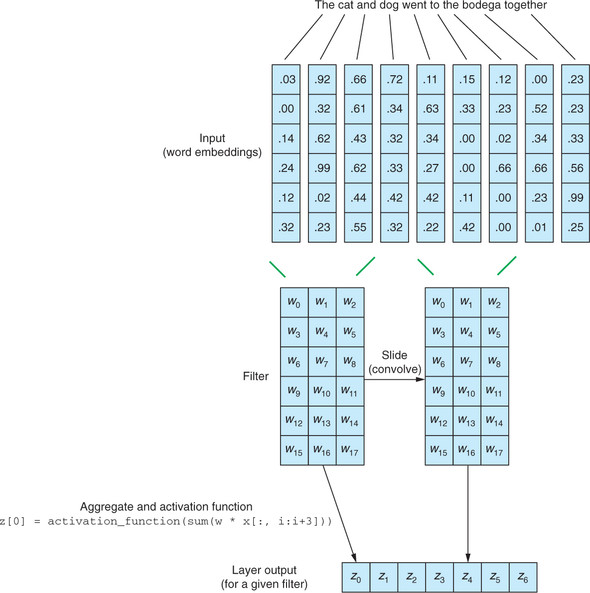

만약 빈 값이 있으면 계산에서 에러가 나기 때문에 거기엔 0값을 미리 넣어줘야 한다. (Padding and truncating)

아웃풋 레이어의 z들을 다 사용하는게 아니라 z들 중 대표값 하나만 사용한다. (뒤에 Pooling에서 다시 얘기)

-> 계속 업데이트 하기 때문에, 대표값을 써도 정보의 손실이 별로 없다. 그리고 평균 보단 최대값이 더 효과적이다.

### Implementation in Keras: prepping the data

In [3]:
>>> import numpy as np
>>> from keras.preprocessing import sequence
>>> from keras.models import Sequential
>>> from keras.layers import Dense, Dropout, Activation
>>> from keras.layers import Conv1D, GlobalMaxPooling1D

In [16]:
>>> import glob
>>> import os

>>> from random import shuffle

>>> def pre_process_data(filepath):
...     """
...     This is dependent on your training data source but we will
...     try to generalize it as best as possible.
...     """
...     positive_path = os.path.join(filepath, 'pos')
...     negative_path = os.path.join(filepath, 'neg')
...     pos_label = 1
...     neg_label = 0
...     dataset = []
...
...     for filename in glob.glob(os.path.join(positive_path, '*.txt')):
...         with open(filename, 'r') as f:
...             dataset.append((pos_label, f.read()))
...
...     for filename in glob.glob(os.path.join(negative_path, '*.txt')):
...         with open(filename, 'r') as f:
...             dataset.append((neg_label, f.read()))
...
...     shuffle(dataset)
...
...     return dataset

In [27]:
>>> dataset[0]
(1, 'I, as a teenager really enjoyed this movie! Mary Kate and Ashley worked
➥ great together and everyone seemed so at ease. I thought the movie plot was
➥ very good and hope everyone else enjoys it to! Be sure and rent it!! Also 
they had some great soccer scenes for all those soccer players! :)')
copy

In [ ]:
# Vectorizer and tokenizer

>>> from nltk.tokenize import TreebankWordTokenizer
>>> from gensim.models.keyedvectors import KeyedVectors
>>> from nlpia.loaders import get_data
>>> word_vectors = get_data('w2v', limit=200000)

>>> def tokenize_and_vectorize(dataset):
...     tokenizer = TreebankWordTokenizer()
...     vectorized_data = []
...     expected = []
...     for sample in dataset:
...         tokens = tokenizer.tokenize(sample[1])
...         sample_vecs = []
...         for token in tokens:
...             try:
...                 sample_vecs.append(word_vectors[token])
...
...             except KeyError:
...                 pass  # No matching token in the Google w2v vocab
...
...         vectorized_data.append(sample_vecs)
...
...     return vectorized_data

In [ ]:
# Target labels

>>> def collect_expected(dataset):
...     """ Peel off the target values from the dataset """
...     expected = []
...     for sample in dataset:
...         expected.append(sample[0])
...     return expected

>>> vectorized_data = tokenize_and_vectorize(dataset)
>>> expected = collect_expected(dataset)

In [ ]:
# Train/test split

>>> split_point = int(len(vectorized_data)*.8)

>>> x_train = vectorized_data[:split_point_]
>>> y_train_ = expected[:split_point]
>>> x_test = vectorized_data[split_point:]
>>> y_test = expected[split_point:]

In [ ]:
# Padding and truncating your token sequence
# truncating : 예를들어 아이큐가 -500이 나오면 그런건 다 0으로 대체한다.

>>> def pad_trunc(data, maxlen):
...     """
...     For a given dataset pad with zero vectors or truncate to maxlen
...     """
...     new_data = []
 
...
...     # Create a vector of 0s the length of our word vectors
...     zero_vector = []
...     for _ in range(len(data[0][0])):
...         zero_vector.append(0.0)
...
...     for sample in data:
...         if len(sample) > maxlen:
...             temp = sample[:maxlen]
...         elif len(sample) < maxlen:
...             temp = sample
...             # Append the appropriate number 0 vectors to the list
...             additional_elems = maxlen - len(sample)
...             for _ in range(additional_elems):
...                 temp.append(zero_vector)
...         else:
...             temp = sample
...         new_data.append(temp)
...     return new_data

In [ ]:
#  Gathering your augmented and truncated data

>>> x_train = pad_trunc(x_train, maxlen)
>>> x_test = pad_trunc(x_test, maxlen)

>>> x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
>>> y_train = np.array(y_train)
>>> x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
>>> y_test = np.array(y_test)

### Convolutional neural network architecture

In [ ]:
>>> model = Sequential()
 
>>> model.add(Conv1D(
...    filters,
...    kernel_size,
...    padding='valid',
...    activation='relu',
...    strides=1,
...    input_shape=(maxlen, embedding_dims)))

###  Pooling

아웃풋 레이어의 z들 중 대표값(최대값) 하나만 사용한다.

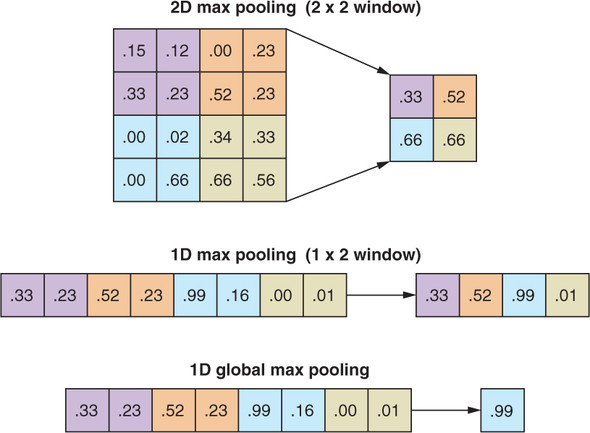

In [ ]:
>>> model.add(GlobalMaxPooling1D())

### Dropout

과소추정보다 과대추정(과적합)이 모형의 예측엔 더 안 좋기 때문에 약간의 dropout을 실시한다.

데이터를 약간 버림?

In [ ]:
# Fully connected layer with dropout

>>> model.add(Dense(hidden_dims))
>>> model.add(Dropout(0.2))
>>> model.add(Activation('relu'))

### The cherry on the sundae

In [ ]:
>>> model.add(Dense(1))
>>> model.add(Activation('sigmoid'))

In [ ]:
# compile the CNN

>>> model.compile(loss='binary_crossentropy',  # 로스 펑션
...               optimizer='adam',            # 최적화 펑션
...               metrics=['accuracy'])

In [ ]:
# Output layer for categorical variable (word)

>>> model.add(Dense(num_classes))
>>> model.add(Activation('sigmoid'))

In [ ]:
# Training a CNN

>>> model.fit(x_train, y_train,
...           batch_size=batch_size,
...           epochs=epochs,
...           validation_data=(x_test, y_test))

In [ ]:
# Save the work  모델 저장

>>> model_structure = model.to_json()
>>> with open("cnn_model.json", "w") as json_file:
...     json_file.write(model_structure)
>>> model.save_weights("cnn_weights.h5")

### Using the model in a pipeline

In [ ]:
>>> from keras.models import model_from_json
>>> with open("cnn_model.json", "r") as json_file:  # 저장한거 불러오기 
...     json_string = json_file.read()
>>> model = model_from_json(json_string)

>>> model.load_weights('cnn_weights.h5') # 저장해놨던 긍정 부정에 대한 웨이트 불러오기

In [ ]:
>>> sample_1 = "I hate that the dismal weather had me down for so long, \\\
when will it break! Ugh, when does happiness return? The sun is blinding \\\
and the puffy clouds are too thin. I can't wait for the weekend."

In [ ]:
# prediction

>>> vec_list = tokenize_and_vectorize([(1, sample_1)])
 
>>> test_vec_list = pad_trunc(vec_list, maxlen)
 
>>> test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen,\
...     embedding_dims))
>>> model.predict(test_vec)
array([[ 0.12459087]], dtype=float32)  # 0.5가 쓰레스홀드이고, 0이 부정, 1이 긍정이면 이 문장은 부정에 가깞다. 